[View in Colaboratory](https://colab.research.google.com/github/kk60258/autoencoder/blob/master/MNIST_Autoencoder.ipynb)

In [0]:
# Install the latest Tensorflow version.
!pip -q install --quiet "tensorflow>=1.7"
# Install imageio for creating animations.  
!pip -q install imageio
!pip -q install scikit-image

In [12]:
!ls

datalab


In [13]:
os.chdir('Deep-Convolutional-AutoEncoder')

NameError: ignored

In [30]:
!ls

ConvolutionalAutoEncoder.py  graph-run1.png  graph-run2.png  README.md


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Step 1: Minibatch Loss: 0.255757
Step 1000: Minibatch Loss: 0.033598
Step 2000: Minibatch Loss: 0.028445
Step 3000: Minibatch Loss: 0.031033
Step 4000: Minibatch Loss: 0.026439
Step 5000: Minibatch Loss: 0.026834
Step 6000: Minibatch Loss: 0.022948
Step 7000: Minibatch Loss: 0.026867
Step 8000: Minibatch Loss: 0.024962
Step 9000: Minibatch Loss: 0.025261
Step 10000: Minibatch Loss: 0.023013
Step 11000: Minibatch Loss: 0.025427
Step 12000: Minibatch Loss: 0.026404
Step 13000: Minibatch Loss: 0.027268
Step 14000: Minibatch Loss: 0.020208
Step 15000: Minibatch Loss: 0.020134
Step 16000: Minibatch Loss: 0.023824
Step 17000: Minibatch Loss: 0.021965
Step 18000: Minibatch Loss: 0.023128
Step 19000: Minibatch Loss: 0.021107
Step 20000: Minibatch Loss: 0.020576
Step 21000: Minibatch Loss: 0.019354
Step 2200

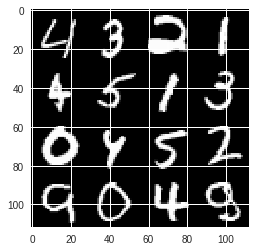

Reconstructed Images


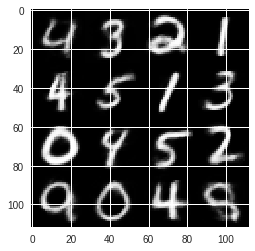

In [2]:
""" Auto Encoder Example.
Build a 2 layers auto-encoder with TensorFlow to compress images to a
lower latent space and then reconstruct them.
References:
    Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based
    learning applied to document recognition." Proceedings of the IEEE,
    86(11):2278-2324, November 1998.
Links:
    [MNIST Dataset] http://yann.lecun.com/exdb/mnist/
Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
"""
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True, source_url='http://yann.lecun.com/exdb/mnist/')

# Training Parameters
learning_rate = 0.01
num_steps = 10000
batch_size = 32

display_step = 1000
examples_to_show = 10

# Network Parameters
num_hidden_1 = 256 # 1st layer num features
num_hidden_2 = 128 # 2nd layer num features (the latent dim)
num_input = 784 # MNIST data input (img shape: 28*28)

tf.reset_default_graph()
# tf Graph input (only pictures)
X = tf.placeholder(tf.float32, [None, num_input])

mode = tf.placeholder(tf.bool)

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([num_input])),
}

def max_unpool_2x2(x, output_shape):
    out = tf.concat([x, tf.zeros_like(x)], 3)
    out = tf.concat([out, tf.zeros_like(out)], 2)
    out_size = output_shape
    return tf.reshape(out, out_size)

def max_pool_2x2(x):
    _, argmax = tf.nn.max_pool_with_argmax(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    pool = tf.nn.max_pool(x, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    return pool, argmax
  
# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2


# Building the decoder
def decoder(x):
    # Decoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

# Building the encoder
def encoder_cnn(layer):
    # Encoder Hidden layer with sigmoid activation #1
    layer = tf.reshape(tensor=layer, shape=[-1, 28, 28, 1])
    layer = tf.layers.conv2d(inputs=layer, filters=64, kernel_size=[3, 3], strides=[1, 1], padding='same', activation=tf.nn.relu, kernel_regularizer=None, name='conv1')
    layer = tf.layers.max_pooling2d(inputs=layer, pool_size=[2, 2], strides=[2, 2], padding='same', name = 'max_pool')
    layer = tf.layers.conv2d(inputs=layer, filters=32, kernel_size=[3, 3], strides=[1, 1], padding='same', activation=tf.nn.relu, kernel_regularizer=None, name='conv2')
    layer = tf.layers.max_pooling2d(inputs=layer, pool_size=[2, 2], strides=[2, 2], padding='same', name = 'max_pool')
    layer = tf.layers.flatten(inputs=layer, name='flatten_c')
    layer = tf.layers.dense(inputs=layer, activation=tf.nn.relu, units=10, name='fc_e1')

    # layer = tf.layers.batch_normalization(inputs=x, training=mode)
    return layer


# Building the decoder
def decoder_cnn(layer):
    layer = tf.layers.dense(inputs=layer, activation=tf.nn.sigmoid, units=49, name='fc_d1')
    layer = tf.reshape(tensor=layer, shape=[-1, 7, 7, 1])
    layer = tf.image.resize_nearest_neighbor(images=layer, size=[layer.shape[1] * 2, layer.shape[2] * 2])
    layer = tf.layers.conv2d_transpose(inputs=layer, filters=32, kernel_size=[3, 3], strides=[1, 1], padding='same', activation=tf.nn.sigmoid, name='conv_trans1')
    layer = tf.image.resize_nearest_neighbor(images=layer, size=[layer.shape[1] * 2, layer.shape[2] * 2])
    layer = tf.layers.conv2d_transpose(inputs=layer, filters=64, kernel_size=[3, 3], strides=[1, 1], padding='same', activation=tf.nn.sigmoid, name='conv_trans2')
    layer = tf.layers.flatten(inputs=layer, name='flatten_d')
    layer = tf.layers.dense(inputs=layer, activation=tf.nn.sigmoid, units=784, name='fc_d2')
    return layer

# Construct model
encoder_op = encoder_cnn(X)
decoder_op = decoder_cnn(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start Training
# Start a new TF session
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # Training
    for i in range(1, num_steps+1):
        # Prepare Data
        # Get the next batch of MNIST data (only images are needed, not labels)
        batch_x, _ = mnist.train.next_batch(batch_size)

        # Run optimization op (backprop) and cost op (to get loss value)
        _, l = sess.run([optimizer, loss], feed_dict={X: batch_x})
        # Display logs per step
        if i % display_step == 0 or i == 1:
            print('Step %i: Minibatch Loss: %f' % (i, l))

    # Testing
    # Encode and decode images from test set and visualize their reconstruction.
    n = 4
    canvas_orig = np.empty((28 * n, 28 * n))
    canvas_recon = np.empty((28 * n, 28 * n))
    for i in range(n):
        # MNIST test set
        batch_x, _ = mnist.test.next_batch(n)
        # Encode and decode the digit image
        g = sess.run(decoder_op, feed_dict={X: batch_x})

        # Display original images
        for j in range(n):
            # Draw the original digits
            canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = \
                batch_x[j].reshape([28, 28])
        # Display reconstructed images
        for j in range(n):
            # Draw the reconstructed digits
            canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = \
                g[j].reshape([28, 28])

    print("Original Images")
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_orig, origin="upper", cmap="gray")
    plt.show()

    print("Reconstructed Images")
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_recon, origin="upper", cmap="gray")
    plt.show()